In [1]:
# import packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

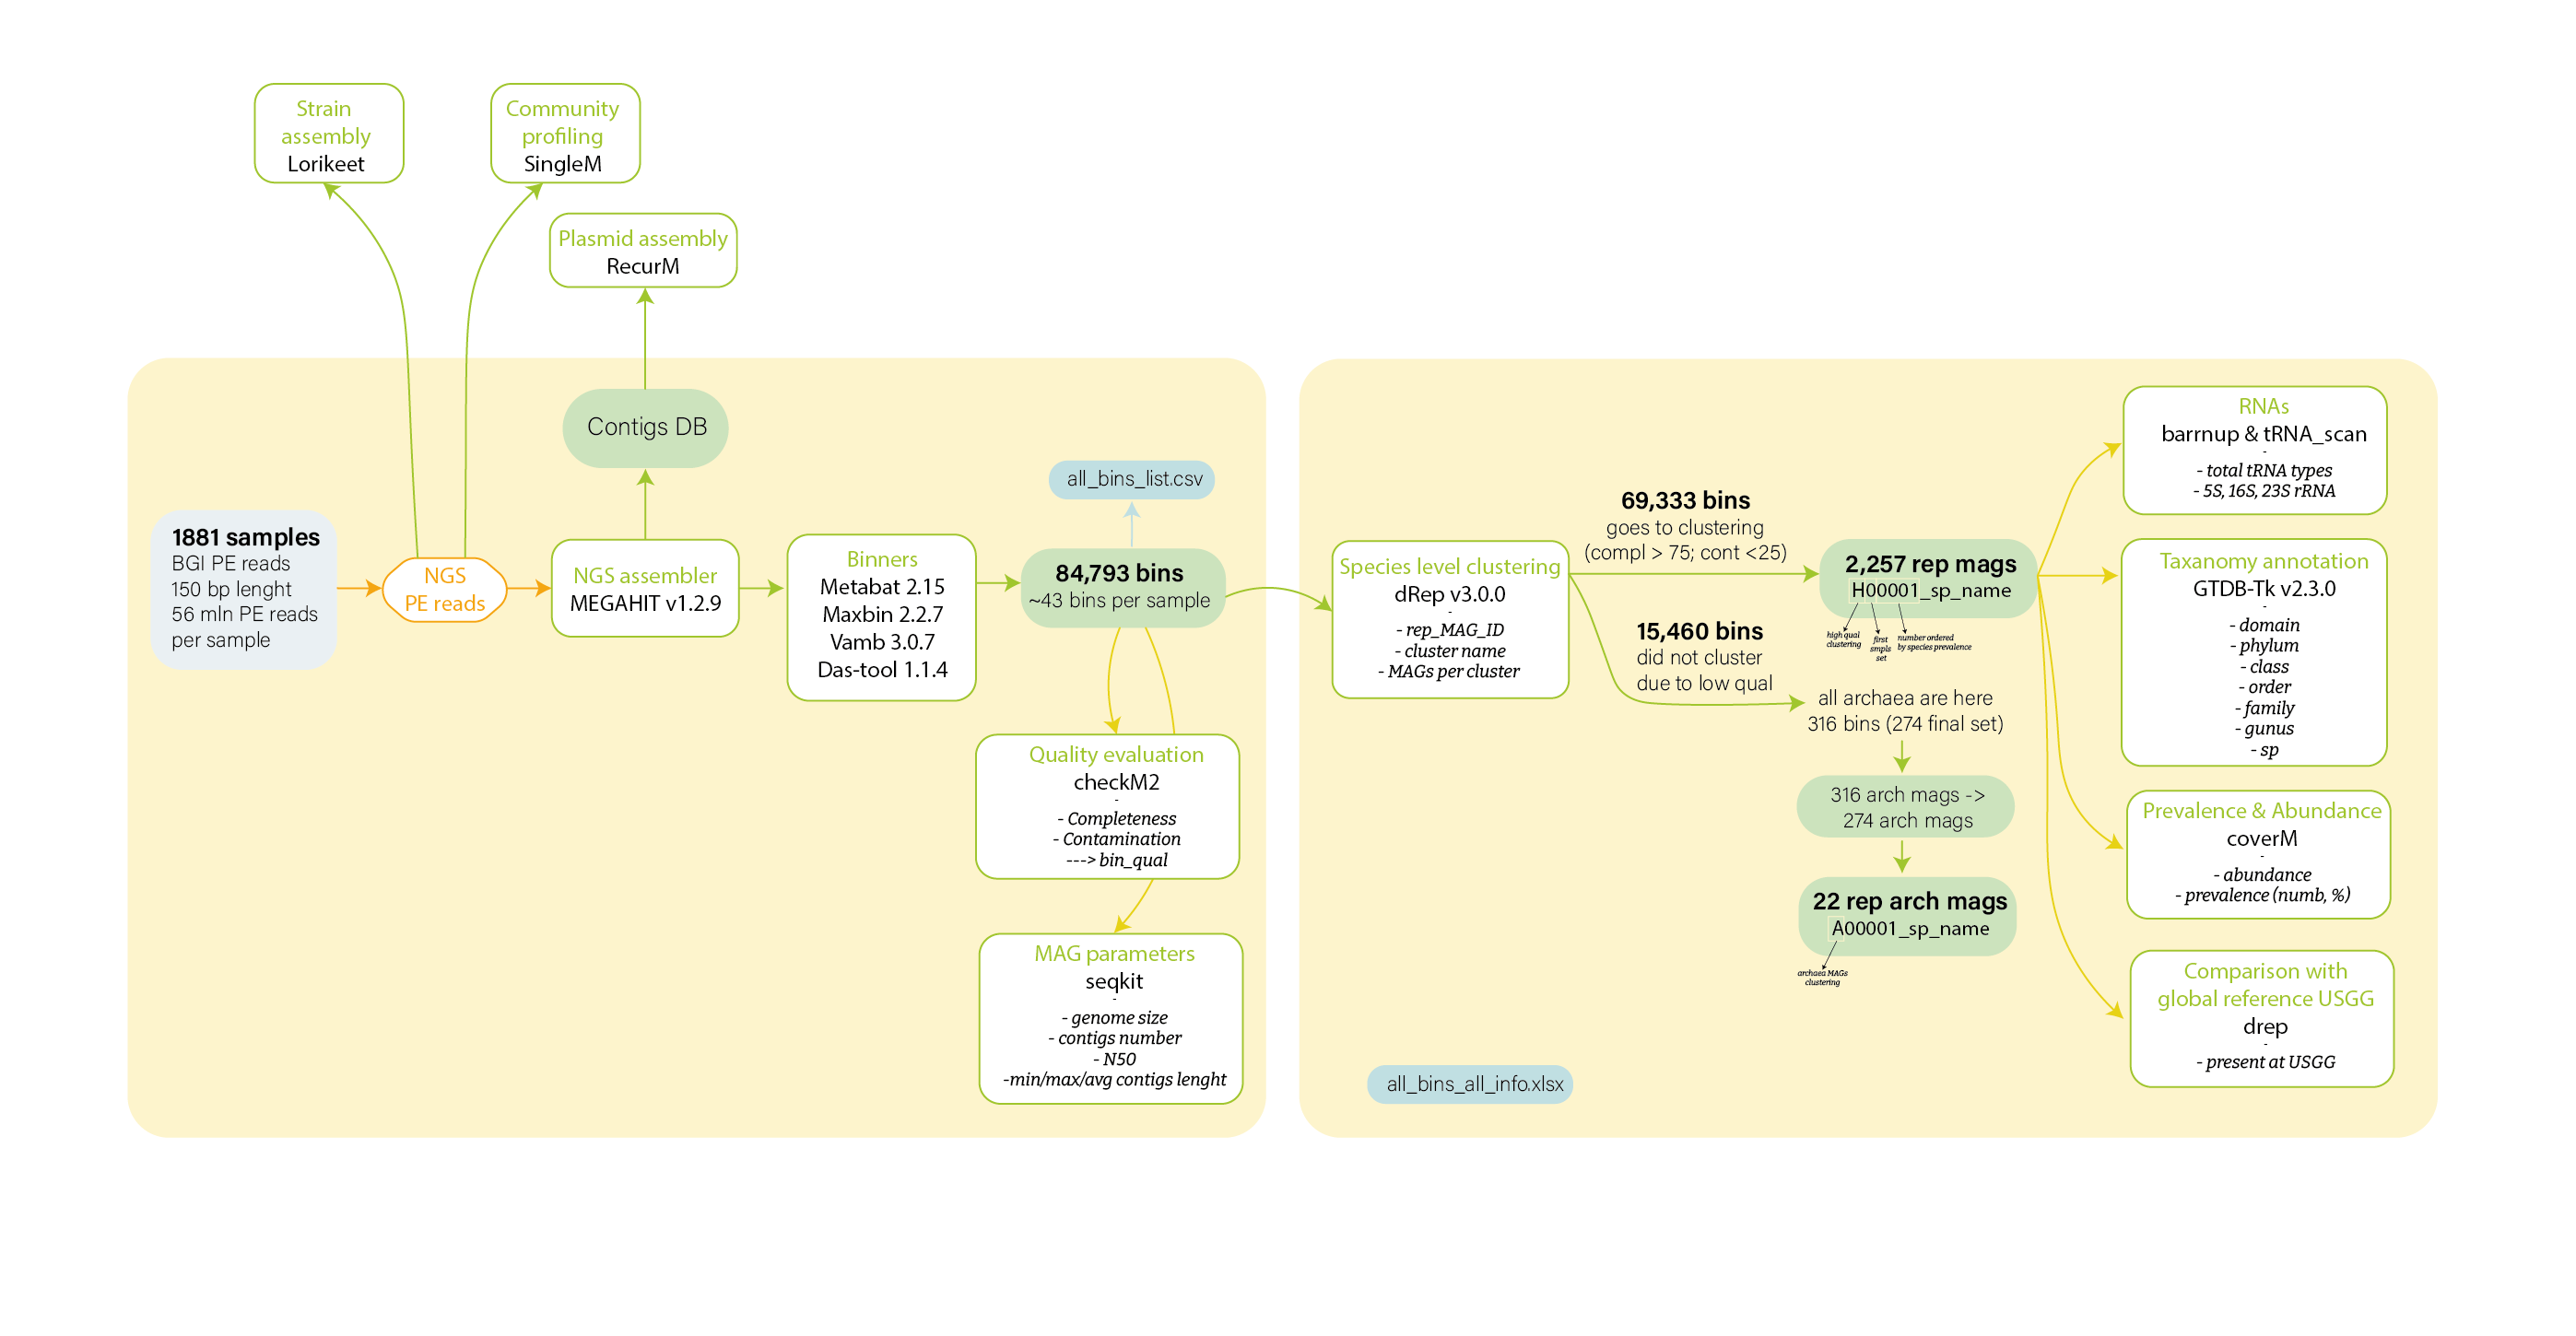

### Source of info

- <b>Rep MAG list</b> <i>2023_Pantiukh_EstMB_MAGsDB_Hqcl.csv</i>

list of representatives genomes (for HQ clustering run). Created with 'ls * all dereplicated 

- <b>All MAGs input evaluation by drep</b> <i>HQ_genomeInformation folder</i>

info about completeness,contamination,strain_heterogeneity,length,N50. Created with dREP (84,761 lines in 10 files. All bins including LQcl bins)

- <b>Taxanomic annotation</b> <i>HQ_gtdbtk.bac120.summary.tsv</i>

taxonomic info about representitives MAGs from HQ clusterin for Bacteria sp. Created with GTDB-tk v2.0 (2,256 lines)

- <b>Quality evaluation</b> <i>???</i>

Completeness & contamination, CheckM2 results

- **HQ_Cdb folder** - info about pre-cluster. Created with dREP (69,332 lines)
- **HQ_Cdb.csv** - info about final clusters. Created with dREP (9,815 lines)
- **2023_Pantiukh_EstMB_MAGsDB_Hqcl.csv** - list of representatives genomes from cluster. Created with 'ls * all dereplicated 
  
### Сalculated parameters 
- **bins_in_cluster** - calculated here based on final table
- **bin_qual** - calculated here based on final table

### Manualy added info
- **rep_MAG_ID** - manually added. Format: [H][0001][sp_name] were H - HQ clustering, 0001 - number, based on bacteria prevalence, sp_name - in case of unknow undS (unknown species)

In [18]:
## Step 0. Read 10 genomeInformation files.
# Read 10 genomeInformation files for pre-clustering process. Get all bins includes LQ bins (84,761 lines)
genomeInformation = pd.DataFrame(columns=['genome', 'completeness', 'contamination', 'strain_heterogeneity','length', 'N50', 'centrality'])

for n in range(1,11):

    gen = pd.read_csv('./input/HQ_genomeInformation/genomeInformation_'+str(n)+'.csv')
    genomeInformation = pd.concat([genomeInformation, gen], ignore_index=True)

# drop & rename columns
genomeInformation = genomeInformation.drop(columns=['centrality'])  
genomeInformation.columns = ['bin_name', 'drep_Completeness', 'drep_Contamination', 'drep_strain_heterogeneity','drep_length', 'drep_N50']

# add cm2 results

# add seqkit results
sq = pd.read_csv('input/seqkit_all_bins.txt', sep='\t')
print('Number of bins from seqkit are present in drep', len(sq[sq['file'].isin(list(genomeInformation['bin_name']))]))
print('Number of bins from drep are present in seqkit', len(genomeInformation[genomeInformation['bin_name'].isin(list(sq['file']))]))
sq = sq[['file', 'num_seqs', 'sum_len', 'min_len', 'avg_len', 'max_len']].copy()
sq.columns = ['bin_name', 'seqkit_cont_numb', 'seqkit_genome_len', 'seqkit_min_cont_len', 'seqkit_avg_cont_len', 'seqkit_max_cont_len']

genomeInformation = pd.merge(genomeInformation, sq, on='bin_name', how='left')

#genomeInformation.to_excel('results/all_bins_all_info.xlsx', index=False)
genomeInformation.tail()

Number of bins from seqkit are present in drep 84762
Number of bins from drep are present in seqkit 84762


,bin_name,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50,seqkit_cont_numb,seqkit_genome_len,seqkit_min_cont_len,seqkit_avg_cont_len,seqkit_max_cont_len
84757,VZZW6V_vamb.182971.fa,87.93,0.00,0.0,1489809,19724,96,1489809,2609,15518.8,74747
84758,VZZW6V_vamb.205379.fa,81.03,1.72,0.0,983639,85642,21,983639,6956,46840.0,125361
84759,VZZW6V_vamb.213811.fa,34.48,5.17,100.0,877739,96766,17,877739,852,51631.7,171722
84760,VZZW6V_vamb.51578.fa,100.00,0.00,0.0,1571046,525634,5,1571046,67770,314209.2,761826
84761,VZZW6V_vamb.76515.fa,99.14,13.79,100.0,1752869,228975,18,1752869,7441,97381.6,438298


In [19]:
# List of columns to be processed
columns_to_process = [
    'seqkit_genome_len',
    'seqkit_avg_cont_len',
    'seqkit_min_cont_len',
    'seqkit_max_cont_len',
    'seqkit_cont_numb',
    'drep_N50',
    'drep_length'
]

# Replace 'NA' with np.nan and convert columns to float
for column in columns_to_process:
    if column in genomeInformation.columns:
        genomeInformation[column] = genomeInformation[column].replace('NA', np.nan).astype(float)

# Check the data types of the columns
print(genomeInformation.dtypes)

bin_name                      object
drep_Completeness            float64
drep_Contamination           float64
drep_strain_heterogeneity    float64
drep_length                  float64
drep_N50                     float64
seqkit_cont_numb             float64
seqkit_genome_len            float64
seqkit_min_cont_len          float64
seqkit_avg_cont_len          float64
seqkit_max_cont_len          float64
dtype: object


In [17]:
## Step 1. Add info about pre-cluster (69,332 lines in 10 files)
cluster = pd.DataFrame(columns=['bin_name', 'pre_cluster'])

for n in range(1, 11):
    clst = pd.read_csv('./input/HQ_Cdb/Cdb_' + str(n) + '.csv')
    # rename column genome
    clst = clst.rename(columns={'genome': 'bin_name'})
    # keep only bin name and cluster columns
    clst = clst[['bin_name', 'secondary_cluster']]
    clst = clst.rename(columns={'secondary_cluster': 'pre_cluster'})
    clst['pre_cluster'] = 'pre'+str(n)+'-'+clst['pre_cluster'].astype(str)
    cluster = pd.concat([cluster, clst], ignore_index=True)

# merge cluster info with genome info
mrg_st1 = pd.merge(cluster, genomeInformation, on='bin_name', how='inner')
mrg_st1.tail()


,bin_name,pre_cluster,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50
69328,VZY957_maxbin.064_sub.fa,pre10-63_1,77.59,20.14,0.00,4519669,2971
69329,VZY957_vamb.139249.fa,pre10-677_1,91.38,0.00,0.00,2292055,54149
69330,VZY957_vamb.70285.fa,pre10-51_1,90.88,0.00,0.00,1482390,23601
69331,VZZW6V_maxbin.057.fa,pre10-573_1,88.87,16.80,8.51,1895208,1552
69332,VZZW6V_vamb.205379.fa,pre10-141_1,81.03,1.72,0.00,983639,85642


In [19]:
## Step 1a. Add info about final HQ cluster (9,815 lines in file)
fclst = pd.read_csv('./input/HQ_Cdb.csv')
# rename column genome
fclst = fclst.rename(columns={'genome': 'bst_preCl_bin_name'})
fclst = fclst.rename(columns={'secondary_cluster': 'cluster'})

fclst['cluster'] = 'HQ-'+fclst['cluster'].astype(str)
fclst = fclst[['bst_preCl_bin_name', 'cluster']]
mrg = pd.merge(fclst, mrg_st1, left_on='bst_preCl_bin_name', right_on='bin_name', how='inner')
mrg = mrg[['bst_preCl_bin_name','pre_cluster','cluster']]
# add info about final cluster to the merged table
mrg_st1a = pd.merge(mrg_st1, mrg, on='pre_cluster', how='outer')
mrg_st1a = mrg_st1a.drop(columns=['pre_cluster'])
mrg_st1a = mrg_st1a.drop(columns=['bst_preCl_bin_name'])
#
mrg_st1a.tail()

,bin_name,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50,cluster
69328,VZY957_maxbin.064_sub.fa,77.59,20.14,0.00,4519669,2971,HQ-227_1
69329,VZY957_vamb.139249.fa,91.38,0.00,0.00,2292055,54149,HQ-645_1
69330,VZY957_vamb.70285.fa,90.88,0.00,0.00,1482390,23601,HQ-230_1
69331,VZZW6V_maxbin.057.fa,88.87,16.80,8.51,1895208,1552,HQ-552_1
69332,VZZW6V_vamb.205379.fa,81.03,1.72,0.00,983639,85642,HQ-384_1


In [25]:
## Step 2. Add info about representative genomes
representative = pd.read_csv('input/2023_Pantiukh_EstMB_MAGsDB_HQcl.csv')
# define cluster name for each representative MAGs 
mrg = pd.merge(representative, mrg_st1a, left_on='rep_MAG_bin_name', right_on='bin_name', how='inner')
mrg = mrg[['rep_MAG_bin_name', 'cluster']]
# add ino about rep_MAG to mrg1
mrg_st2 = pd.merge(mrg_st1a, mrg, on='cluster', how='outer')

mrg_st2.tail()


,bin_name,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50,cluster,rep_MAG_bin_name
69328,VZQLWU_vamb.11899.fa,93.97,0.00,0.00,2279068,46770,HQ-9_1,VZQLWU_vamb.11899.fa
69329,VZWEWM_maxbin.066.fa,100.00,1.72,0.00,2448674,149658,HQ-52_1,VZWEWM_maxbin.066.fa
69330,VZXIHP_metabat.131.fa,92.24,2.59,33.33,2452983,20640,HQ-1099_1,VZXIHP_metabat.131.fa
69331,VZXIHP_metabat.45.fa,98.28,1.72,0.00,1774424,55805,HQ-1187_1,VZXIHP_metabat.45.fa
69332,VZXIHP_metabat.71.fa,91.38,6.35,85.71,1595826,6604,HQ-1822_1,VZXIHP_metabat.71.fa


In [34]:
## Step 3. Add info about taxonomy

# READ bacteria taxonomy
gt = pd.read_csv('input/HQ_gtdbtk.bac120.summary.tsv', sep='\t')
gt = gt[['user_genome','classification','fastani_ani','closest_placement_reference','closest_placement_ani']]

gt['domain'] = gt['classification'].str.split(';', expand=True)[0].str.replace(r'd__', '')
gt['phylum'] = gt['classification'].str.split(';', expand=True)[1].str.replace(r'p__', '')
gt['class'] = gt['classification'].str.split(';', expand=True)[2].str.replace(r'c__', '')
gt['order'] = gt['classification'].str.split(';', expand=True)[3].str.replace(r'o__', '')
gt['family'] = gt['classification'].str.split(';', expand=True)[4].str.replace(r'f__', '')
gt['genus'] = gt['classification'].str.split(';', expand=True)[5].str.replace(r'g__', '')
gt['sp'] = gt['classification'].str.split(';', expand=True)[6].str.replace(r's__', '')
gt = gt.drop('classification', axis=1)

# rename column genome
gt = gt.rename(columns={'user_genome': 'rep_MAG_bin_name'})
# skip columns 
gt = gt[['rep_MAG_bin_name', 'domain', 'phylum', 'class', 'order', 'family', 'genus', 'sp']]
# fill NaN empty values with value
gt['sp'] = gt['sp'].replace('', 'undefined')
gt['genus'] = gt['genus'].replace('', 'undefined')
gt['family'] = gt['family'].replace('', 'undefined')

# add fa to rep_MAG_name
gt['rep_MAG_bin_name'] = gt['rep_MAG_bin_name'].astype(str)+'.fa'

# add ino about taxonomy to mrg_st2
mrg_st3 = pd.merge(mrg_st2, gt, left_on='rep_MAG_bin_name', right_on='rep_MAG_bin_name', how='outer')

mrg_st3.head(2)

,bin_name,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50,cluster,rep_MAG_bin_name,domain,phylum,class,order,family,genus,sp
0,V0404P_175861.fa,84.48,0.0,0.0,2184033,60660,HQ-613_1,VV3FPX_vamb.54158.fa,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,Limisoma,Limisoma sp000437795
1,V1T1XL_vamb.223401.fa,91.38,0.0,0.0,2306061,74991,HQ-613_1,VV3FPX_vamb.54158.fa,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,Limisoma,Limisoma sp000437795


In [35]:
## Step 4. Add info about bins number in cluster
bn = mrg_st3[['bin_name','cluster']].groupby('cluster').count()
# rename column
bn = bn.rename(columns={'bin_name': 'bin_number_in_cluster'})
# merge it with mrg_st3
mrg_st4 = pd.merge(mrg_st3, bn, on='cluster', how='outer')

mrg_st4.tail()

,bin_name,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50,cluster,rep_MAG_bin_name,domain,phylum,class,order,family,genus,sp,bin_number_in_cluster
69328,VZQLWU_vamb.11899.fa,93.97,0.00,0.00,2279068,46770,HQ-9_1,VZQLWU_vamb.11899.fa,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema_D,Treponema_D porcinum,1
69329,VZWEWM_maxbin.066.fa,100.00,1.72,0.00,2448674,149658,HQ-52_1,VZWEWM_maxbin.066.fa,Bacteria,Pseudomonadota,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Oxalobacter,undefined,1
69330,VZXIHP_metabat.131.fa,92.24,2.59,33.33,2452983,20640,HQ-1099_1,VZXIHP_metabat.131.fa,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Bilophila,undefined,1
69331,VZXIHP_metabat.45.fa,98.28,1.72,0.00,1774424,55805,HQ-1187_1,VZXIHP_metabat.45.fa,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Ruminococcaceae,Angelakisella,Angelakisella sp004554485,1
69332,VZXIHP_metabat.71.fa,91.38,6.35,85.71,1595826,6604,HQ-1822_1,VZXIHP_metabat.71.fa,Bacteria,Bacillota_A,Clostridia,Christensenellales,Borkfalkiaceae,Gallimonas,Gallimonas faecium,1


Moove to representatives MAGs from cluster

In [37]:
## Step 5. Select only representative MAGs
mrg_st5 = pd.merge(representative, mrg_st4, left_on='rep_MAG_bin_name', right_on='bin_name', how='inner')
# rename column genome
#mrg_st5 = mrg_st5.rename(columns={'rep_MAG_name_x': 'rep_MAG_name'})
# drop column centrality
#mrg_st5 = mrg_st5.drop(columns=['bin_name','rep_MAG_name_y'])
mrg_st5.tail()

,rep_MAG_bin_name_x,bin_name,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50,cluster,rep_MAG_bin_name_y,domain,phylum,class,order,family,genus,sp,bin_number_in_cluster
2252,VZXIHP_metabat.45.fa,VZXIHP_metabat.45.fa,98.28,1.72,0.00,1774424,55805,HQ-1187_1,VZXIHP_metabat.45.fa,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Ruminococcaceae,Angelakisella,Angelakisella sp004554485,1
2253,VZXIHP_metabat.47.fa,VZXIHP_metabat.47.fa,100.00,0.00,0.00,1681331,16994,HQ-21_1,VZXIHP_metabat.47.fa,Bacteria,Pseudomonadota,Alphaproteobacteria,RF32,CAG-239,MGBC133411,MGBC133411 sp017935485,10
2254,VZXIHP_metabat.71.fa,VZXIHP_metabat.71.fa,91.38,6.35,85.71,1595826,6604,HQ-1822_1,VZXIHP_metabat.71.fa,Bacteria,Bacillota_A,Clostridia,Christensenellales,Borkfalkiaceae,Gallimonas,Gallimonas faecium,1
2255,VZXIHP_vamb.13313.fa,VZXIHP_vamb.13313.fa,98.28,0.00,0.00,1802309,62695,HQ-541_1,VZXIHP_vamb.13313.fa,Bacteria,Pseudomonadota,Gammaproteobacteria,Burkholderiales,Burkholderiaceae_A,Aphodousia,Aphodousia sp905201055,3
2256,VZXIHP_vamb.28684.fa,VZXIHP_vamb.28684.fa,98.28,0.00,0.00,2339340,167392,HQ-1830_1,VZXIHP_vamb.28684.fa,Bacteria,Bacillota_A,Clostridia,Christensenellales,HGM11417,HGM11417,undefined,3


In [12]:
## Step 6. Add info about rep_MAG_ID
mid = pd.read_csv('input/HQ_rename_v2.csv', sep='\t')
mrg_st6 = pd.merge(mrg_st5, mid, on='rep_MAG_name', how='inner')
mrg_st6.tail()


,rep_MAG_name,pre_cluster,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50,bst_preCl_bin_name,cluster,domain,phylum,class,order,family,genus,sp,bin_number_in_cluster,rep_MAG_ID_name
2252,VZXIHP_metabat.45.fa,pre10-338_1,98.28,1.72,0.00,1774424,55805,VZXIHP_metabat.45.fa,HQ-1187_1,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Ruminococcaceae,Angelakisella,Angelakisella sp004554485,1,H01581_Angelakisella_sp004554485.fa
2253,VZXIHP_metabat.47.fa,pre10-749_1,100.00,0.00,0.00,1681331,16994,VZXIHP_metabat.47.fa,HQ-21_1,Bacteria,Pseudomonadota,Alphaproteobacteria,RF32,CAG-239,MGBC133411,MGBC133411 sp017935485,10,H00712_MGBC133411_sp017935485.fa
2254,VZXIHP_metabat.71.fa,pre10-454_1,91.38,6.35,85.71,1595826,6604,VZXIHP_metabat.71.fa,HQ-1822_1,Bacteria,Bacillota_A,Clostridia,Christensenellales,Borkfalkiaceae,Gallimonas,Gallimonas faecium,1,H01845_Gallimonas_faecium.fa
2255,VZXIHP_vamb.13313.fa,pre10-581_1,98.28,0.00,0.00,1802309,62695,VZXIHP_vamb.13313.fa,HQ-541_1,Bacteria,Pseudomonadota,Gammaproteobacteria,Burkholderiales,Burkholderiaceae_A,Aphodousia,Aphodousia sp905201055,3,H01204_Aphodousia_sp905201055.fa
2256,VZXIHP_vamb.28684.fa,pre10-243_1,98.28,0.00,0.00,2339340,167392,VZXIHP_vamb.28684.fa,HQ-1830_1,Bacteria,Bacillota_A,Clostridia,Christensenellales,HGM11417,HGM11417,undefined,3,H01164_HGM11417_undS.fa


In [13]:
## Step 7. Add info about rep_MAG_ID to all bins
mrg_st7 = pd.merge(mrg_st4, mid, on='rep_MAG_name', how='left')
mrg_st7.tail()


,bin_name,pre_cluster,drep_Completeness,drep_Contamination,drep_strain_heterogeneity,drep_length,drep_N50,bst_preCl_bin_name,cluster,rep_MAG_name,domain,phylum,class,order,family,genus,sp,bin_number_in_cluster,rep_MAG_ID_name
69328,VZQLWU_vamb.11899.fa,pre10-73_1,93.97,0.00,0.00,2279068,46770,VZQLWU_vamb.11899.fa,HQ-9_1,VZQLWU_vamb.11899.fa,Bacteria,Spirochaetota,Spirochaetia,Treponematales,Treponemataceae,Treponema_D,Treponema_D porcinum,1,H02216_Treponema_D_porcinum.fa
69329,VZWEWM_maxbin.066.fa,pre10-735_1,100.00,1.72,0.00,2448674,149658,VZWEWM_maxbin.066.fa,HQ-52_1,VZWEWM_maxbin.066.fa,Bacteria,Pseudomonadota,Gammaproteobacteria,Burkholderiales,Burkholderiaceae,Oxalobacter,undefined,1,H02007_Oxalobacter_undS.fa
69330,VZXIHP_metabat.131.fa,pre10-305_1,92.24,2.59,33.33,2452983,20640,VZXIHP_metabat.131.fa,HQ-1099_1,VZXIHP_metabat.131.fa,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Bilophila,undefined,1,H01542_Bilophila_undS.fa
69331,VZXIHP_metabat.45.fa,pre10-338_1,98.28,1.72,0.00,1774424,55805,VZXIHP_metabat.45.fa,HQ-1187_1,VZXIHP_metabat.45.fa,Bacteria,Bacillota_A,Clostridia,Oscillospirales,Ruminococcaceae,Angelakisella,Angelakisella sp004554485,1,H01581_Angelakisella_sp004554485.fa
69332,VZXIHP_metabat.71.fa,pre10-454_1,91.38,6.35,85.71,1595826,6604,VZXIHP_metabat.71.fa,HQ-1822_1,VZXIHP_metabat.71.fa,Bacteria,Bacillota_A,Clostridia,Christensenellales,Borkfalkiaceae,Gallimonas,Gallimonas faecium,1,H01845_Gallimonas_faecium.fa


## Save the files

In [19]:
# SAVE FINAL TABLE with all bins went to LQcl
mrg_st7.to_excel('results/HQcl_all_bins_all_info.xlsx', index=False)

/var/folders/fr/j_4kmkcj6zs6nglntg64jfgr0000gn/T/ipykernel_1146/2190587524.py:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.1' currently installed).
  mrg_st7.to_excel('results/HQcl_all_bins_all_info.xlsx', index=False)


In [13]:
# SAVE FINAL TABLE with only representative MAGs came from LQcl
mrg_st6.to_excel('results/HQcl_representative_MAGs_all_info.xlsx', index=False)

/var/folders/fr/j_4kmkcj6zs6nglntg64jfgr0000gn/T/ipykernel_1146/2511518551.py:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.1' currently installed).
  mrg_st6.to_excel('results/HQcl_representative_MAGs_all_info.xlsx', index=False)


In [ ]:
# Step 4a. Change it to source as imput cm2 results insted of drep!!
conditions = [(mrg_st4['completeness'] > 90) & (mrg_st4['contamination'] < 5),
        (mrg_st4['completeness'] <= 90) & (mrg_st4['contamination'] < 10) | \
        (mrg_st4['completeness'] > 90) & (mrg_st4['contamination'] >= 5) & (mrg_st4['contamination'] < 10),
        (mrg_st4['contamination'] >= 10)]

values = ['HQ', 'MQ', 'LQ']
mrg_st4['bin_qual'] = np.select(conditions, values)